In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import cv2 as cvlib
from matplotlib.pyplot import imshow
import numpy
import pylab
import wave
import array
from scipy import signal
# from sklearn.model_selection import train_test_split

In [ ]:
def getSpectrogram(sig, factor):
  n_fft = 510 # frame length
  hop_length = int(1102 * factor)
  stft = librosa.stft(sig.astype('f'), n_fft=n_fft, hop_length=hop_length, )
  stft_magnitude, stft_phase = librosa.magphase(stft)
  stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

  spectrogramimg=cvlib.resize(stft_magnitude_db, dsize=(299, 299), interpolation=cvlib.INTER_CUBIC)

  result = np.ones((256, 256))
  result[:, 0:201] = stft_magnitude_db
  # plt.figure()
  # imshow(result, origin='lower')
  # print(result[256, 0])
  return result

In [ ]:
def getSpectrograms(path, with_resample):
  resampling_factors = [1, 0.6, 0.9, 1.1,]
  w1 = wave.open(path)
  
  x1 = numpy.array(array.array('h', w1.readframes(w1.getnframes())))
  x1 = x1 / ((2**(16-1))*1.0)  # normalize

  result = []

  if with_resample:
    fs = 220500
    resampled_x_list = []
    for factor in resampling_factors:
      resampled_x = signal.resample(x1, int(factor * fs))
      resampled_x_list.append(resampled_x)

    for index, resampled_x in enumerate(resampled_x_list):
      result.append(getSpectrogram(resampled_x, resampling_factors[index]))

  else:
    result = [getSpectrogram(x1, 1)]

  return result

In [ ]:
import pandas as pd 
data = pd.read_csv('/content/drive/MyDrive/ESC-50-master/meta/esc50.csv')
data = data[['filename', 'target']]
X_full = np.empty((6500, 256, 256))
for i in range(1500): 
  if i % 100 == 0: 
    print(i)
  path = '/content/drive/MyDrive/ESC-50-master/audio/' + data['filename'].loc[i] 
  result = getSpectrograms(path, True) 
  # print(np.array(result).shape)
  X_full[i*4:i*4+4] = np.array(result)

for i in range(1500, 2000): 
  if i % 100 == 0: 
    print(i)
  path = '/content/drive/MyDrive/ESC-50-master/audio/' + data['filename'].loc[i] 
  result = getSpectrograms(path, False) 
  X_full[4500 + i] = np.array(result)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [ ]:
# X_full = pd.DataFrame(X_full)
# X_full = np.array(X_full)
X_full.shape

(6500, 256, 256)

In [ ]:
# import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
K.set_image_data_format('channels_last')
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow

In [ ]:
def AlexNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    X = Dense(50,activation='softmax',name = 'fc2')(X)
    
    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    model.compile(optimizer = 'sgd' , loss = 'sparse_categorical_crossentropy' , metrics=['accuracy'])
    return model

In [ ]:
Y_full = np.empty((6500,))
for i in range(1500):
  Y_full[i*4] = data['target'].iloc[i]
  Y_full[i*4+1] = data['target'].iloc[i]
  Y_full[i*4+2] = data['target'].iloc[i]
  Y_full[i*4+3] = data['target'].iloc[i]

Y_full[6000:] = data['target'].iloc[1500:]

import random
indexes = random.sample(range(6000), 6000)
X_tr_full = X_full[0:6000]
Y_tr_full = Y_full[0:6000]

X_ts = X_full[6000:]
Y_ts = Y_full[6000:]
print(X_tr_full.shape)
print(Y_tr_full.shape)
print(X_ts.shape)
print(Y_ts.shape)

(6000, 256, 256)
(6000,)
(500, 256, 256)
(500,)


In [ ]:
myAlex = AlexNet((256, 256, 1))
myAlex.fit(X_tr_full, Y_tr_full, epochs=50)

Epoch 1/50
188/188 [==============================] - 17s 47ms/step - loss: 3.7826 - accuracy: 0.1117
Epoch 2/50
188/188 [==============================] - 9s 47ms/step - loss: 2.0628 - accuracy: 0.3976
Epoch 3/50
188/188 [==============================] - 9s 46ms/step - loss: 1.3221 - accuracy: 0.5981
Epoch 4/50
188/188 [==============================] - 9s 46ms/step - loss: 0.8157 - accuracy: 0.7428
Epoch 5/50
188/188 [==============================] - 8s 45ms/step - loss: 0.5427 - accuracy: 0.8409
Epoch 6/50
188/188 [==============================] - 8s 45ms/step - loss: 0.3255 - accuracy: 0.9068
Epoch 7/50
188/188 [==============================] - 8s 45ms/step - loss: 0.1946 - accuracy: 0.9478
Epoch 8/50
188/188 [==============================] - 8s 45ms/step - loss: 0.1319 - accuracy: 0.9661
Epoch 9/50
188/188 [==============================] - 8s 45ms/step - loss: 0.1057 - accuracy: 0.9744
Epoch 10/50
188/188 [==============================] - 8s 45ms/step - loss: 0.0715 - accur

In [ ]:
myAlex.evaluate(X_ts, Y_ts)

16/16 [==============================] - 1s 24ms/step - loss: 2.0566 - accuracy: 0.5500


[2.0566024780273438, 0.550000011920929]

In [ ]:
myAlex = AlexNet((256, 256, 1))
history = myAlex.fit(X_tr_full, Y_tr_full, epochs=15)

Epoch 1/15
188/188 [==============================] - 13s 63ms/step - loss: 3.7559 - accuracy: 0.1173
Epoch 2/15
188/188 [==============================] - 12s 63ms/step - loss: 1.9980 - accuracy: 0.4140
Epoch 3/15
188/188 [==============================] - 12s 62ms/step - loss: 1.2891 - accuracy: 0.6135
Epoch 4/15
188/188 [==============================] - 12s 63ms/step - loss: 0.7681 - accuracy: 0.7650
Epoch 5/15
188/188 [==============================] - 12s 62ms/step - loss: 0.4706 - accuracy: 0.8569
Epoch 6/15
188/188 [==============================] - 12s 63ms/step - loss: 0.3060 - accuracy: 0.9119
Epoch 7/15
188/188 [==============================] - 12s 63ms/step - loss: 0.1785 - accuracy: 0.9523
Epoch 8/15
188/188 [==============================] - 12s 63ms/step - loss: 0.1294 - accuracy: 0.9665
Epoch 9/15
188/188 [==============================] - 12s 63ms/step - loss: 0.0849 - accuracy: 0.9790
Epoch 10/15
188/188 [==============================] - 12s 63ms/step - loss: 0.061

In [ ]:
myAlex.evaluate(X_ts, Y_ts)

16/16 [==============================] - 1s 31ms/step - loss: 2.2083 - accuracy: 0.5280


[2.208284378051758, 0.527999997138977]

In [ ]:
import pandas as pd
# import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
# import matplotlib.pyplot as plt

def plot_loss(history):
  history_df = pd.DataFrame(history.history)
  history_df.plot(figsize=(8, 6))
  return

def plot_heat_map(y_test, y_pred, label_list):
  conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
  conf_matrix = pd.DataFrame(conf_matrix, index=label_list, columns=label_list)
  # conf_mat_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize = (20,15))
  plt.title('Spectrogram SGD')
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', )
  plt.savefig('res_spec_SGD.png')
  plt.figure(figsize = (60,50))
  plt.title('Spectrogram SGD(%)')
  sns.heatmap(conf_matrix/np.sum(conf_matrix, axis=0), annot=True, fmt='.2%', cmap='Blues')
  plt.savefig('res_percentage_spec_SGD.png')
  # plt.ylabel('True label')
  # plt.xlabel('Predicted label')
  return

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


ValueError: ignored

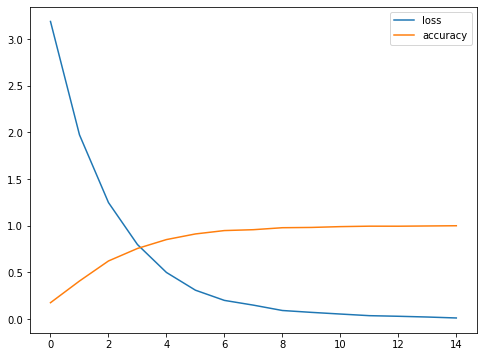

In [ ]:
plot_loss(history)

labels=['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep',
        'crow', 'rain', 'sea_waves', 'crackling_fire', 'crickets', 
        'chirping_birds', 'water_drops', 'wind', 'pouring_water',
        'toilet_flush', 'thunderstorm', 'crying_baby', 'sneezing', 'clapping',
        'breathing', 'coughing', 'footsteps', 'laughing', 'brushing_teeth',
        'snoring', 'drinking_sipping', 'door_wood_knock', 'mouse_click',
        'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine',
        'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking',
        'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train',
        'church_bells', 'airplane', 'fireworks', 'hand_saw']
plot_heat_map(Y_ts, myAlex.predict(X_ts), labels)